# **Galaxy Classification**

Galaxy Classification with Python/R, colab.

Data Wrangling with Python

Data: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data


The Galaxy Zoo 2 decision tree: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview/the-galaxy-zoo-decision-tree

**Data Description**

1. images_training: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

2. solutions_training: Probability distributions for the classifications for each of the training images.

3. images_test: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. 

4. all_ones_benchmark: Sample submission file corresponding to the All Ones Benchmark

5. all_zeros_benchmark: Sample submission file corresponding to the All Zeros Benchmark

6. central_pixel_benchmark: Simple benchmark that clusters training galaxies according to the color in the center of the image and then assigns the associated probability values to like-colored images in the test set.

The first column in each solution is labeled GalaxyID; this is a randomly-generated ID that only allows you to match the probability distributions with the images.

The next 37 columns are all floating point numbers between 0 and 1 inclusive. These represent the morphology (or shape) of the galaxy in 37 different categories as identified by crowdsourced volunteer classifications as part of the Galaxy Zoo 2 project. These morphologies are related to probabilities for each category; a high number (close to 1) indicates that many users identified this morphology category for the galaxy with a high level of confidence. Low numbers for a category (close to 0) indicate the feature is likely not present. 

# Import Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import random
import shutil
import itertools
import glob
import string
import pickle
import json
import re

from bson import json_util

import numpy as np
import matplotlib.image as mpimg
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
print(tf.__version__)
tf.test.gpu_device_name()

2.6.0


''

In [ ]:
# from urllib.request import urlopen
# from io import BytesIO
# from zipfile import ZipFile

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# **Connect and authorize google drive with google colab:**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Connect to Kaggle

Ref: https://galhever.medium.com/how-to-import-data-from-kaggle-to-google-colab-8160caa11e2

Install the Kaggle package that will be used for importing the data.

In [ ]:
!pip install kaggle

Next, we need to upload the credentials of our Kaggle account. To do so, you need to enter your profile and “Create New API Token”. If you already have one you can click on “Expire API Token” and create a new one.

Then, save the json file with your credentials on your computer and upload this file to Colab using the code below:

In [ ]:
from google.colab import files
files.upload()

The Kaggle API client expects the json file to be in ~/.kaggle folder so let’s create a new folder and move it inside.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Next, we will click on the three vertical points on the right side of the screen and “Copy the API Command” of the dataset that we want to import from Kaggle.

Download data from Galaxy Zoo: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data

In [ ]:
! kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

In [ ]:
!pwd

/content


In [ ]:
!ls

sample_data


In [ ]:
!unzip "/content/gdrive/My Drive/data/galaxy_data/images_training_rev1.zip"

In [ ]:
!unzip "/content/gdrive/My Drive/data/galaxy_data/training_solutions_rev1.zip"

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('images_training_rev1.zip', 'r')
zip_ref.extractall('/content/gdrive/My Drive/data/galaxy_data/')
zip_ref.close()

# Data

**Project "Galaxy Classifier" directory in google drive:**

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/galaxy_classifier/
!ls

**Data for "Galaxy Classifier" directory in google drive:**

In [ ]:
%cd /content/gdrive/My Drive/data/galaxy_data/
!ls

In [ ]:
%cd /content/gdrive/My Drive/data/galaxy_data/images_training_rev1
! ls -l | wc -l

/content/gdrive/My Drive/data/galaxy_data/images_training_rev1
61579


Total number of images in "image_training_rev1" is 61579 - 1 = 61578. Perfect! Because there are 61578 galaxies for training.

In [ ]:
data_dir = os.path.join('/content/gdrive/My Drive/data', 'galaxy_data')

training_solutions = os.path.join(data_dir, 'training_solutions_rev1.csv')
training_images    = os.path.join(data_dir, 'images_training_rev1')

print(data_dir)
print(training_solutions)
print(training_images)

/content/gdrive/My Drive/data/galaxy_data
/content/gdrive/My Drive/data/galaxy_data/training_solutions_rev1.csv
/content/gdrive/My Drive/data/galaxy_data/images_training_rev1


# Read the training probablilities CVS file to a pandas dataframe.

In [ ]:
# data frame
df = pd.read_csv(training_solutions)
df.head(3)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.00000,0.0,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.0,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.45995,0.0,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
# Replace Column names ('Class' -> 'T' (Task), just to shorten the codes)
df.columns = list( map(lambda s: s.replace('Class', 'T'), df.columns ) )

print('Columns: ', df.columns)
print('Number of galaxies: ', df.shape[0]) # (61578, 38)
print('Number of Classes (or columns): ', df.shape[1]) # (61578, 38)

Columns:  Index(['GalaxyID', 'T1.1', 'T1.2', 'T1.3', 'T2.1', 'T2.2', 'T3.1', 'T3.2',
       'T4.1', 'T4.2', 'T5.1', 'T5.2', 'T5.3', 'T5.4', 'T6.1', 'T6.2', 'T7.1',
       'T7.2', 'T7.3', 'T8.1', 'T8.2', 'T8.3', 'T8.4', 'T8.5', 'T8.6', 'T8.7',
       'T9.1', 'T9.2', 'T9.3', 'T10.1', 'T10.2', 'T10.3', 'T11.1', 'T11.2',
       'T11.3', 'T11.4', 'T11.5', 'T11.6'],
      dtype='object')
Number of galaxies:  61578
Number of Classes (or columns):  38


# Galaxy Class definition

Only interested in 07 major types of galaxies:
(See Tables 1 & 2 in https://arxiv.org/pdf/2008.13611.pdf).

- Completely round smooth;
- In-between smooth
- Cigar shaped smooth
- Lenticulars
- Barred spirals
- Unbarred spirals
- Irregular

Select subsets of images in the Galaxy Zoo dataset based on the probabilities distributions available in the CSV file. The entire dataset is comprised of 61578 images.

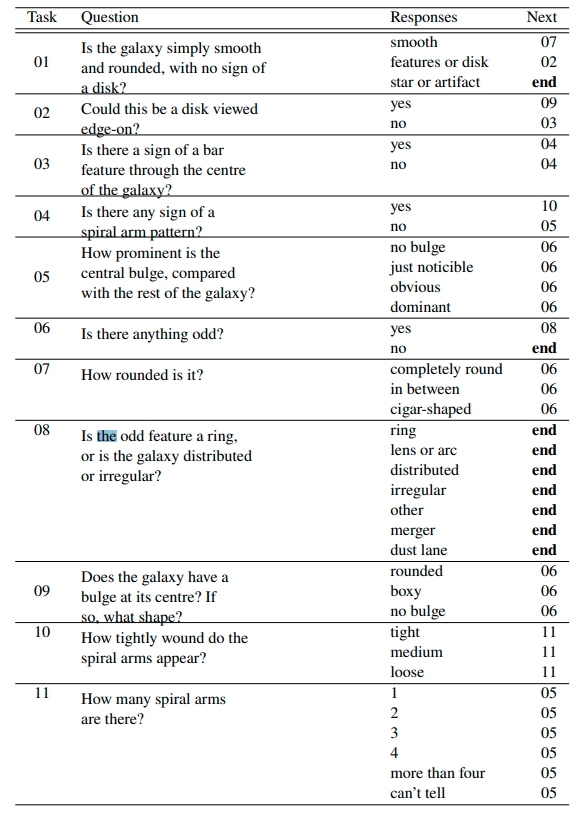

**Note:** Take a look at the above table.

The columns in csv file are related to the Questions and Responses of the above table.

For instance:

Column T1.1 means Question 1 - Response 1 (i.e: Task 01 and its Question and Response = "Smooth")

Column T6.2 means Question 6 - Response 2 (i.e: Task 06 and its question and Response = "No")

and so on ...

Define the galaxy types:

In [ ]:
# Define the galaxy classes
completely_round_smooth = df[ (df['T1.1'] >= 0.469) & (df['T7.1'] >= 0.5) & (df['T6.2'] >= 0.5)]['GalaxyID'].tolist()
in_between_smooth       = df[ (df['T1.1'] >= 0.469) & (df['T7.2'] >= 0.5) & (df['T6.2'] >= 0.5)]['GalaxyID'].tolist()
cigar_shaped_smooth     = df[ (df['T1.1'] >= 0.469) & (df['T7.3'] >= 0.5) & (df['T6.2'] >= 0.5)]['GalaxyID'].tolist()
lenticulars             = df[ (df['T1.2'] >= 0.430) & (df['T2.1'] >= 0.602) & (df['T6.2'] >= 0.5)]['GalaxyID'].tolist()
barred_spirals          = df[ (df['T1.2'] >= 0.430) & (df['T2.2'] >= 0.715) & (df['T3.1'] >= 0.715) & (df['T4.1'] >= 0.619)]['GalaxyID'].tolist()
unbarred_spirals        = df[ (df['T1.2'] >= 0.430) & (df['T2.2'] >= 0.715) & (df['T3.2'] >= 0.715) & (df['T4.1'] >= 0.619)]['GalaxyID'].tolist()
irregular               = df[ (df['T6.1'] >= 0.420) & ( (df['T8.3'] >= 0.5) | (df['T8.4'] >= 0.5) | (df['T8.5'] >= 0.5) | (df['T8.6'] >= 0.5)  | (df['T8.7'] >= 0.5) ) ]['GalaxyID'].tolist()

The number of samples for each class:

In [ ]:
n_rounds            = len(completely_round_smooth)
n_in_betweens       = len(in_between_smooth)
n_barred_spirals    = len(barred_spirals)
n_cigars            = len(cigar_shaped_smooth)
n_lenticulars       = len(lenticulars)
n_unbarred_spirals  = len(unbarred_spirals)
n_irregulars        = len(irregular)

print('Total number of completely round smooth samples: {0}'.format(n_rounds) )
print('Total number of in-between smooth samples: {0}'.format(n_in_betweens) )
print('Total number of cigar shaped smooth samples: {0}'.format(n_cigars) )
print('Total number of lenticular samples: {0}'.format(n_lenticulars) )
print('Total number of barred spiral samples: {0}'.format(n_barred_spirals) )
print('Total number of unbarred spiral samples: {0}'.format(n_unbarred_spirals) )
print('Total number of irregular samples: {0}'.format(n_irregulars) )

Total number of completely round smooth samples: 7929
Total number of in-between smooth samples: 7624
Total number of cigar shaped smooth samples: 574
Total number of lenticular samples: 3716
Total number of barred spiral samples: 827
Total number of unbarred spiral samples: 3367
Total number of irregular samples: 1568


In [ ]:
# Check
completely_round_smooth[:5]

In [ ]:
# Class names and number of images
classes = {
    "names" : ['completely round smooth', 'in between smooth', 'cigar shaped smooth', 'lenticulars', 'barred spirals', 'unbarred spirals', 'irregular'],
    "length" : [7929, 7624, 574, 3716, 827, 3367, 1568]
}

In [ ]:
# To dataframe
class_df = pd.DataFrame(classes)
class_df.index.tolist()

In [ ]:
class_df = class_df.sort_values(by="length", ascending=True)

In [ ]:
class_df

,names,length
2,cigar shaped smooth,574
4,barred spirals,827
6,irregular,1568
5,unbarred spirals,3367
3,lenticulars,3716
1,in between smooth,7624
0,completely round smooth,7929


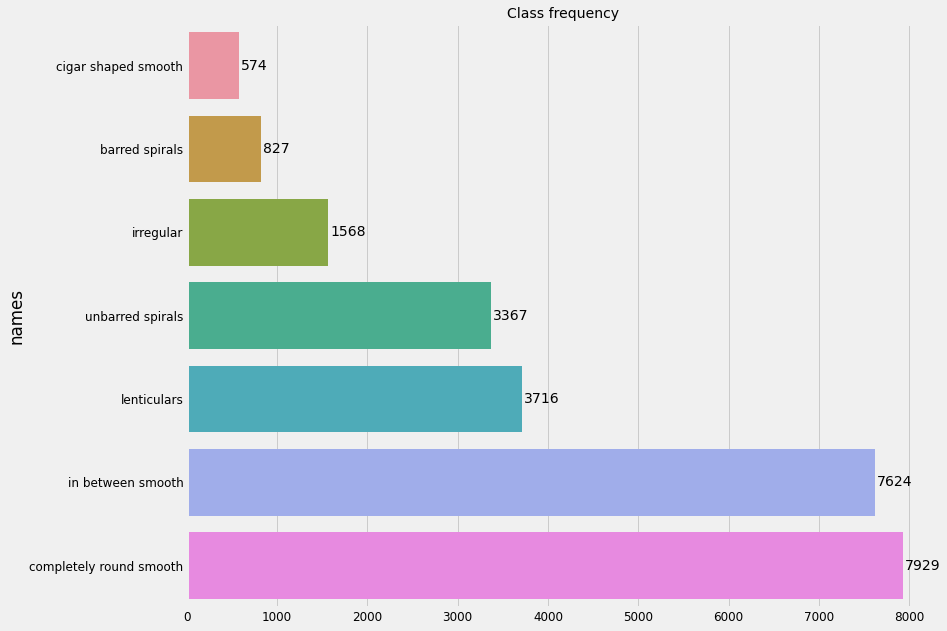

In [ ]:
# Bar plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,10))

# Note that: x = length, y = class_names
ax = sns.barplot(x=class_df["length"], y=class_df["names"])

for p in ax.patches:
  width = p.get_width()    # get bar length
  ax.text(width + 20,       # set the text at 20 unit right of the bar
    p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
    '{:1.0f}'.format(width), # set variable to display, 2 decimals
    ha = 'left',   # horizontal alignment
    va = 'center')  # vertical alignment


plt.title("Class frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Note: In this case, we should use class_weight method to deal with unbalanced dataset.

# Split to training/validation sets

In [ ]:
# Create directories for training and validation datasets
training_dir = os.path.join(data_dir, 'training')
valid_dir    = os.path.join(data_dir, 'validation')

if not os.path.exists(training_dir):
	os.makedirs(training_dir)

if not os.path.exists(valid_dir):
	os.makedirs(valid_dir)		

print(data_dir)
print(valid_dir)
print(training_dir)

/content/gdrive/My Drive/data/galaxy_data
/content/gdrive/My Drive/data/galaxy_data/validation
/content/gdrive/My Drive/data/galaxy_data/training


In [ ]:
# Create a function that randomly copies the images for a given class (label)
# to the corresponding training and validation directories,
# these are later used in the datasets generators:

def _split_training_valid_datasets(cat_data, category = '', train_ratio = 0.75):
	training_dest = os.path.join(training_dir, category)
	valid_dest    = os.path.join(valid_dir, category)

	if not os.path.exists(training_dest):
		os.makedirs(training_dest)

	if not os.path.exists(valid_dest):
		os.makedirs(valid_dest)

	random.shuffle(cat_data)

	idx = int( len(cat_data) * train_ratio )

	for i in cat_data[:idx]:
		shutil.copyfile( os.path.join(training_images, str(i)+'.jpg'), os.path.join(training_dest, str(i)+'.jpg') )

	for i in cat_data[idx:]:
		shutil.copyfile( os.path.join(training_images, str(i)+'.jpg'), os.path.join(valid_dest, str(i)+'.jpg') )
	
	print(category + ' <<')
	##
# End - def

In [ ]:
dir_names = class_df["names"].apply(lambda x: x.replace(' ', '_')).values.tolist()
dir_index = class_df.index.tolist()
dir_names = [ str(y) + '_' + x for (x,y) in zip(dir_names, dir_index)]
dir_names

['2_cigar_shaped_smooth',
 '4_barred_spirals',
 '6_irregular',
 '5_unbarred_spirals',
 '3_lenticulars',
 '1_in_between_smooth',
 '0_completely_round_smooth']

In [ ]:
# Split into the training and validation sets for each galaxy type
run_split = True
if run_split:
  # _split_training_valid_datasets(completely_round_smooth, category = '0_completely_round_smooth', train_ratio = 0.75)
  _split_training_valid_datasets(in_between_smooth, category = '1_in_between_smooth', train_ratio = 0.75)
  _split_training_valid_datasets(cigar_shaped_smooth, category = '2_cigar_shaped_smooth', train_ratio = 0.75)
  _split_training_valid_datasets(lenticulars, category = '3_lenticulars', train_ratio = 0.75)
  _split_training_valid_datasets(barred_spirals, category = '4_barred_spirals', train_ratio = 0.75)
  _split_training_valid_datasets(unbarred_spirals, category = '5_unbarred_spirals', train_ratio = 0.75)
  _split_training_valid_datasets(irregular, category = '6_irregular', train_ratio = 0.75)

1_in_between_smooth <<
2_cigar_shaped_smooth <<
3_lenticulars <<
4_barred_spirals <<
5_unbarred_spirals <<
6_irregular <<


In [ ]:
len(os.listdir('/content/gdrive/My Drive/data/galaxy_data/images_training_rev1'))

61578

In [ ]:
# Check the total number of training and validation samples:
n_round_train           = len(os.listdir(os.path.join(data_dir, 'training', '0_completely_round_smooth')))
n_inbetween_train       = len(os.listdir(os.path.join(data_dir, 'training', '1_in_between_smooth')))
n_cigar_train           = len(os.listdir(os.path.join(data_dir, 'training', '2_cigar_shaped_smooth')))
n_lenticular_train      = len(os.listdir(os.path.join(data_dir, 'training', '3_lenticulars')))
n_barred_spriral_train  = len(os.listdir(os.path.join(data_dir, 'training', '4_barred_spirals')))
n_unbarred_spiral_train = len(os.listdir(os.path.join(data_dir, 'training', '5_unbarred_spirals')))
n_irregular_train       = len(os.listdir(os.path.join(data_dir, 'training', '6_irregular')))
print('Total train 0_completely_round_smooth:', n_round_train)
print('Total train 1_in_between_smooth:', n_inbetween_train)
print('Total train 2_cigar_shaped_smooth:', n_cigar_train)
print('Total train 3_lenticulars:', n_lenticular_train)
print('Total train 4_barred_spirals:', n_barred_spriral_train)
print('Total train 5_unbarred_spirals:', n_unbarred_spiral_train)
print('Total train 6_irregular:', n_irregular_train)

print()
print()
n_round_valid           = len(os.listdir(os.path.join(data_dir, 'validation', '0_completely_round_smooth')))
n_inbetween_valid       = len(os.listdir(os.path.join(data_dir, 'validation', '1_in_between_smooth')))
n_cigar_valid           = len(os.listdir(os.path.join(data_dir, 'validation', '2_cigar_shaped_smooth')))
n_lenticular_valid      = len(os.listdir(os.path.join(data_dir, 'validation', '3_lenticulars')))
n_barred_spriral_valid  = len(os.listdir(os.path.join(data_dir, 'validation', '4_barred_spirals')))
n_unbarred_spiral_valid = len(os.listdir(os.path.join(data_dir, 'validation', '5_unbarred_spirals')))
n_irregular_valid       = len(os.listdir(os.path.join(data_dir, 'validation', '6_irregular')))
print('Total validation 0_completely_round_smooth:', n_round_valid)
print('Total validation 1_in_between_smooth:', n_inbetween_valid)
print('Total validation 2_cigar_shaped_smooth:', n_cigar_valid)
print('Total validation 3_lenticulars:', n_lenticular_valid)
print('Total validation 4_barred_spirals:', n_barred_spriral_valid)
print('Total validation 5_unbarred_spirals:', n_unbarred_spiral_valid)
print('Total validation 6_irregular:', n_irregular_valid)

Total train 0_completely_round_smooth: 5946
Total train 1_in_between_smooth: 5718
Total train 2_cigar_shaped_smooth: 430
Total train 3_lenticulars: 2787
Total train 4_barred_spirals: 620
Total train 5_unbarred_spirals: 2525
Total train 6_irregular: 1176


Total validation 0_completely_round_smooth: 1983
Total validation 1_in_between_smooth: 1906
Total validation 2_cigar_shaped_smooth: 144
Total validation 3_lenticulars: 929
Total validation 4_barred_spirals: 207
Total validation 5_unbarred_spirals: 842
Total validation 6_irregular: 392


# Plot some samples

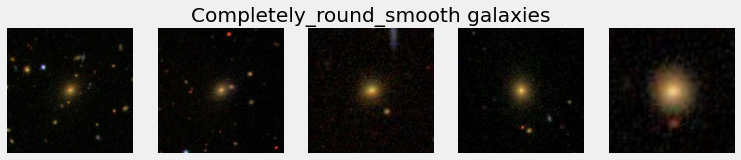

In [ ]:
# Finally, show a few examples from each galaxy class:
from keras_preprocessing import image

# 0_completely_round_smooth class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '0_completely_round_smooth'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '0_completely_round_smooth', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Completely_round_smooth galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

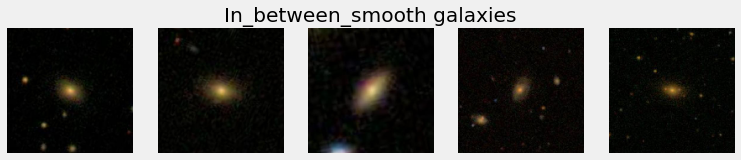

In [ ]:
# 1_in_between_smooth class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '1_in_between_smooth'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '1_in_between_smooth', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('In_between_smooth galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

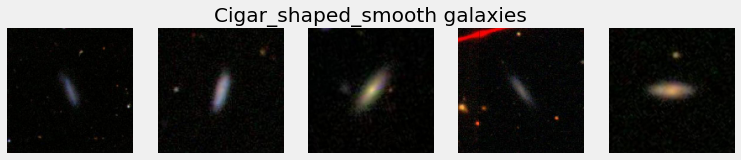

In [ ]:
# 2_cigar_shaped_smooth class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '2_cigar_shaped_smooth'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '2_cigar_shaped_smooth', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Cigar_shaped_smooth galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

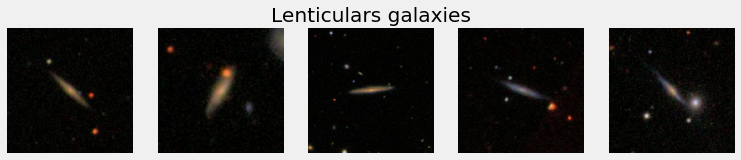

In [ ]:
# 3_lenticulars class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '3_lenticulars'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '3_lenticulars', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Lenticulars galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

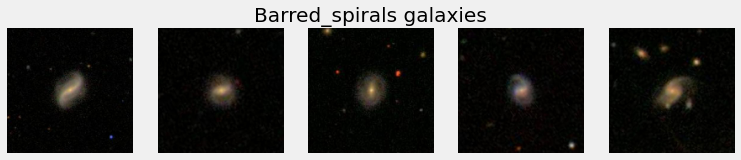

In [ ]:
# 4_barred_spirals class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '4_barred_spirals'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '4_barred_spirals', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Barred_spirals galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

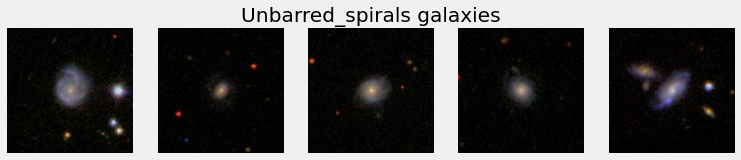

In [ ]:
# 5_unbarred_spirals class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '5_unbarred_spirals'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '5_unbarred_spirals', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Unbarred_spirals galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

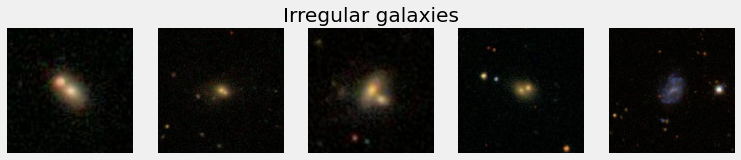

In [ ]:
# 6_irregular class
plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(os.path.join(data_dir, 'training', '6_irregular'))[0:5]):
    img = image.load_img(os.path.join(data_dir, 'training', '6_irregular', file) , target_size=(150, 150))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Irregular galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

# Conclusion



1.   Downloaded data.
2.   Select classes of galaxies.
3.   Split dataset into training/test sets
4.   The number of samples for each classes are different, meaning that the training/valiadtion sets are imbalanced. Need to consider the weights for imbalanced dataset when training the model.



